In [4]:
! nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-a35df308-9768-042a-9ccf-f4318582a58e)


In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import yaml
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set3')

import IPython.display as display
from IPython.display import Video

from PIL import Image
import cv2

import torch

from ultralytics import YOLO

In [7]:
class CFG:
    ### inference: use any pretrained or custom model
    # WEIGHTS = 'yolov8x.pt' # yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt
    WEIGHTS = 'C:\\Users\Acer\\OneDrive\\Рабочий стол\\PPE\model\\yolo-ppe-100-epochs\\runs\\detect\\yolov9e_ppe_css_50_epochs\\weights\\best.pt'
    
    CONFIDENCE = 0.55 # 0.35
    CONFIDENCE_INT = int( round(CONFIDENCE * 100, 0) )
    
    CLASSES_TO_DETECT = [0, 2, 4, 5, 7] # Hardhat, NO-Hardhat, NO-Safety Vest, Person, Safety Vest
    
    VERTICES_POLYGON = np.array([[200,720], [0,700], [500,620], [990,690], [820,720]])

    EXP_NAME = 'ppe'

    ### just some video examples
    VID_001 = 'C:\\Users\Acer\\OneDrive\\Рабочий стол\\PPE\model\\video-example-for-ppe-red-zone\\example_video.mp4'

    ### choose filepath to make inference on (image or video)
    PATH_TO_INFER_ON = VID_001
    EXT = PATH_TO_INFER_ON.split('.')[-1] # get file extension
    FILENAME_TO_INFER_ON = PATH_TO_INFER_ON.split('/')[-1].split('.')[0] # get filename

    ### paths
    ROOT_DIR = 'C:\\Users\Acer\\OneDrive\\Рабочий стол\\PPE\model\\video-example-for-ppe-red-zone\\'
    OUTPUT_DIR = './'

In [8]:
glob.glob(CFG.ROOT_DIR + '*')

['C:\\Users\\Acer\\OneDrive\\Рабочий стол\\PPE\\model\\video-example-for-ppe-red-zone\\example_video.mp4']

In [9]:
def get_image_properties(image):
    if isinstance(image, str):
        # If image is a file path, read the image
        img = cv2.imread(image)
        if img is None:
            raise ValueError("Could not read image file")
    elif isinstance(image, np.ndarray):
        # If image is already a NumPy array, use it directly
        img = image
    else:
        raise ValueError("Input must be a file path or a NumPy array")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [10]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img);
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')
        
    if hide_axis:
        plt.axis('off')
        
    plt.show()

In [11]:
def get_video_properties(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video file is opened successfully
    if not cap.isOpened():
        raise ValueError("Could not open video file")

    # Get video properties
    properties = {
        "fps": int(cap.get(cv2.CAP_PROP_FPS)),
        "frame_count": int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        "duration_seconds": int( cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS) ),
        "width": int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        "height": int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
        "codec": int(cap.get(cv2.CAP_PROP_FOURCC)),
    }

    # Release the video capture object
    cap.release()

    return properties

In [12]:
### testing function
video_properties = get_video_properties(CFG.VID_001)
video_properties

{'fps': 29,
 'frame_count': 697,
 'duration_seconds': 24,
 'width': 1280,
 'height': 720,
 'codec': 877677894}

In [13]:
OUT_VIDEO_NAME = './video_to_infer.mp4'

subprocess.run(
    [
        "C:\\ffmpeg\\bin\\ffmpeg.exe",
        "ffmpeg",  "-i", CFG.PATH_TO_INFER_ON, "-crf",
        "18", "-preset", "veryfast", "-hide_banner", "-loglevel",
        "error", "-vcodec", "libx264", OUT_VIDEO_NAME
    ]
)

Video(data=OUT_VIDEO_NAME, embed=True, height=int(video_properties['height'] * 0.5), width=int(video_properties['width'] * 0.5))

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [10]:
print('File path to make inference on: ', CFG.PATH_TO_INFER_ON)
print('File name to make inference on: ', CFG.FILENAME_TO_INFER_ON)

File path to make inference on:  C:\Users\Khalif\Desktop\Attendance system\model\video-example-for-ppe-red-zone\example_video.mp4
File name to make inference on:  C:\Users\Khalif\Desktop\Attendance system\model\video-example-for-ppe-red-zone\example_video


In [11]:
cap = cv2.VideoCapture(CFG.PATH_TO_INFER_ON)

if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    # Read the first frame
    ret, frame_test = cap.read()
    cap.release()

vertices_polygon = np.array([[200,720], [0,700], [500,620], [990,690], [820,720]]) # manually adjusted

cv2.polylines(frame_test, [vertices_polygon.reshape(-1, 1, 2)], True, (0, 0, 128), 4)

mod = frame_test.copy()
overlay = cv2.fillPoly(mod, pts = [vertices_polygon], color=(0, 0, 128))
background = frame_test.copy()

frame_test = cv2.addWeighted(
    src1 = background, # fisrt image
    alpha = 0.6, # first image weight
    src2 = overlay, # second image
    beta = 0.4, # second image weight
    gamma = 0.1, # scalar factor
    dst = overlay # output array shape
)

Type:  <class 'PIL.Image.Image'> 

Shape:  (720, 1280, 3) 



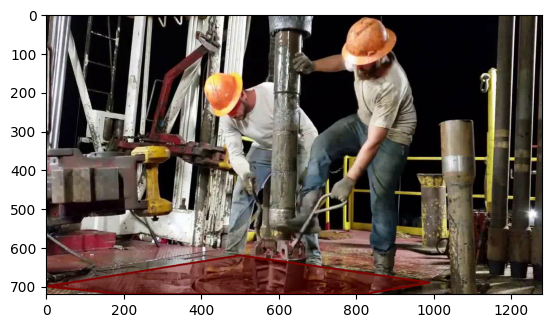

In [12]:
display_image(frame_test)


In [13]:
img_properties = get_image_properties(frame_test)
img_properties

{'width': 1280, 'height': 720, 'channels': 3, 'dtype': dtype('uint8')}

In [14]:
model = YOLO(CFG.WEIGHTS)

In [15]:
print('Device: ', model.device)

Device:  cpu


In [16]:
if torch.cuda.is_available():
    model.to('cuda:0')
else:
    print("CUDA device is not available. Running on CPU.")

CUDA device is not available. Running on CPU.


In [17]:
print('Device: ', model.device)
print('Weights: ', CFG.WEIGHTS)

Device:  cpu
Weights:  C:\Users\Khalif\Desktop\Attendance system\model\yolo-ppe-100-epochs\runs\detect\yolov9e_ppe_css_50_epochs\weights\best.pt


In [18]:
# model.model
model.names

{0: 'Hardhat',
 1: 'Mask',
 2: 'NO-Hardhat',
 3: 'NO-Mask',
 4: 'NO-Safety Vest',
 5: 'Person',
 6: 'Safety Cone',
 7: 'Safety Vest',
 8: 'machinery',
 9: 'vehicle'}

In [ ]:
%%time

results = model.predict(
    source = CFG.PATH_TO_INFER_ON,
    save = True,
    classes = CFG.CLASSES_TO_DETECT,
    conf = CFG.CONFIDENCE,
    save_txt = True,
    save_conf = True,
    show = True,
    device='cpu'
#     stream = True,
)


Ultralytics YOLOv8.2.11  Python-3.9.10 torch-2.3.0+cpu CPU (12th Gen Intel Core(TM) i5-12500H)
YOLOv9e summary (fused): 687 layers, 57384110 parameters, 0 gradients, 189.2 GFLOPs

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/697) C:\Users\Khalif\Desktop\Attendance system\model\video-example-for-ppe-red-zone\example_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 2 Persons, 556.9ms
video 1/1 (frame 2/697) C:\Users\Khalif\Desktop\Attendance system\model\video-example-for-ppe-red-zo

In [21]:
RAW_INFERENCE_VIDEO = glob.glob('C:\\Users\\Khalif\\Desktop\\Attendance system\\model\\video-example-for-ppe-red-zone\\example_video.mp4')[0] # avi or mp4
OUT_VIDEO_NAME = './raw_inference.mp4'

subprocess.run(
    [
        "C:\\ffmpeg\\bin\\ffmpeg.exe",
        "ffmpeg",  "-i", RAW_INFERENCE_VIDEO, "-crf",
        "18", "-preset", "veryfast", "-hide_banner", "-loglevel",
        "error", "-vcodec", "libx264", OUT_VIDEO_NAME
    ]
)

Video(data=OUT_VIDEO_NAME, embed=True, height=int(video_properties['height'] * 0.5), width=int(video_properties['width'] * 0.5))

In [2]:
import cv2
from ultralytics import YOLO

# Конфигурация для загрузки модели
class CFG:
    WEIGHTS = 'C:\\Users\\Khalif\\Desktop\\Attendance system\\model\\yolo-ppe-100-epochs\\runs\\detect\\yolov9e_ppe_css_50_epochs\\weights\\best.pt'
    CONFIDENCE = 0.25
    CLASSES_TO_DETECT = [0, 2, 4, 5, 7]  # Индексы классов: Hardhat, NO-Hardhat, NO-Safety Vest, Person, Safety Vest

# Загрузка предобученной модели YOLO
model = YOLO(CFG.WEIGHTS)
model.conf = CFG.CONFIDENCE  # Установка порога уверенности

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Не удалось открыть камеру.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Получение результатов от модели
    results = model(frame)
    
    # Обход результатов и рисование рамок
    for result in results:
        boxes = result.boxes  # Получение рамок объектов
        
        for box in boxes:
            # Координаты рамки
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Идентификатор класса и его название
            cls_id = int(box.cls[0])
            label = model.names[cls_id]

            # Определение цвета рамки
            if label == 'Hardhat':
                color = (0, 255, 0)  # Зеленый для обнаруженной каски
            elif label == 'NO-Hardhat':
                color = (0, 0, 255)  # Красный для отсутствующей каски
            elif label == 'Safety Vest':
                color = (0, 255, 0)  # Зеленый для обнаруженного жилета
            elif label == 'NO-Safety Vest':
                color = (0, 0, 255)  # Красный для отсутствующего жилета
            else:
                continue

            # Рисование рамки и подписи
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2, cv2.LINE_AA)

    # Отображение кадра с рамками
    cv2.imshow('PPE Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Очистка ресурсов
cap.release()
cv2.destroyAllWindows()



0: 480x640 2 NO-Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 618.8ms
Speed: 2.0ms preprocess, 618.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 NO-Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 1 Person, 584.4ms
Speed: 2.0ms preprocess, 584.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 NO-Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 1 Person, 572.1ms
Speed: 1.0ms preprocess, 572.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 NO-Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 562.6ms
Speed: 2.0ms preprocess, 562.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 NO-Hardhats, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 568.3ms
Speed: 1.0ms preprocess, 568.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 NO-Hardhat, 1 NO-Mask, 2 NO-Safety Vests, 1 Person, 565.2ms
Speed: 1.0ms preprocess, 565.2ms inference, 0.0ms postprocess pe